In [1]:
import json
import glob
import numpy as np
from scipy import sparse
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from drawing import *
import pandas as pd

In [136]:
# Define sorting functiosn

def multiplex_sort(file_string):
    if (file_string.split('m=')[1][1] != '_'):
        # Quick fix for number strings with more than 2 digits to sort properly.
        return int(file_string.split('m=')[1][0:2])
    else:
        return int(file_string.split('m=')[1][0])


def assignment_sort(file_string):
    return int(file_string.split('as=')[1][0])

In [140]:
test_string = '../results/Toric10/results_HGP_n=200_m=2_r=0.0-1.0_as=4.json'
multiplex_sort(test_string)

2

In [104]:
# Function to import and sort data.

def import_files_and_sort_data(folder_name):
    #files_import = glob.glob("../results/n128_sym/*")
    files_import = glob.glob(folder_name+"/*")

    # Initialize a dictionary to store the sorted data.
    # Each key is a fixed value denoting either multiplexing number (m=_) or assignment strategy number (as=_).
    # Each value will be a list of file names corresponding to these fixed values, to be sorted.
    file_dict = {}
    
    # Identify the strategy corresponding to no-multiplexing (m=1), if it exists. There should be only one such file.
    no_mult_file_string = None
    for line_string in files_import:
        if (line_string.find('as=0') != -1):
            no_mult_file_string = line_string


    # Loop through a list of posible multiplexing values and check if these exist.
    for m in range(1,25):
        multiplex_key = 'm='+str(m)
        file_dict[multiplex_key] = []

        # Loop through the files and identify any which use this condition.
        for line_string in files_import:
            if (line_string.find(multiplex_key) != -1):
                file_dict[multiplex_key].append(line_string)

        # After adding all such files, sort the list according to the assignment strategy.
        file_dict[multiplex_key] = sorted(file_dict[multiplex_key],key=assignment_sort)

        # If the no-multiplexing case exists, append this entry to the beginning of the file list.
        if (no_mult_file_string != None):
            file_dict[multiplex_key].insert(0,no_mult_file_string)

    # Loop through a list of the possible assignment strategies checking the same.
    for a in [1,2,3,4,5]:
        as_key = 'as='+str(a)
        file_dict[as_key] = []

        # Loop through the files and identify any which use this condition.
        for line_string in files_import:
            if (line_string.find(as_key) != -1):
                file_dict[as_key].append(line_string)

        # After adding all such files, sort the list according to the multiplexing number.
        file_dict[as_key] = sorted(file_dict[as_key],key=multiplex_sort)

        # If the no-multiplexing case exists, append this entry to the beginning of the file list.
        if (no_mult_file_string != None):
            file_dict[as_key].insert(0,no_mult_file_string)


    # Return this dictionary of sorted files.
    return file_dict

In [5]:
def json_to_data(json_file_name):
    data = open(json_file_name)
    data = json.load(data)
    erasure_rates = data['erasure_rates']
    success_rates = data['success_rates']
    success_rates_error_bars = data['success_rates_error_bars']
    failure_rates = data['failure_rates']
    failure_rates_error_bars = data['failure_rates_error_bars']
    decoding_failure_rates = data['DFrate']
    non_df_le_rates = data['nonDFLErate']

    #label = 'm=' + str(data['num_multiplexing']) + ' , strategy=' + str(data['assignment type'])
    info_dict = {}
    info_dict['Code_length'] = data['Code_length']
    info_dict['Code_dimension'] = data['Code_dimension']
    info_dict['Assignment_type'] = data['assignment type']
    info_dict['num_multiplexing'] = data['num_multiplexing']
    info_dict['num_photons'] = data['num_photons']
    info_dict['num_trials'] = data['num_trials']

    return info_dict, erasure_rates, success_rates, success_rates_error_bars, failure_rates, failure_rates_error_bars, decoding_failure_rates, non_df_le_rates

In [6]:
def read_multiple_jsons(json_file_names):
    list_of_res = []
    for i in json_file_names:
        curve = json_to_data(i)
        list_of_res.append(curve)
    return list_of_res

In [7]:
def read_and_sort_multiple_jsons(json_file_names_dict):
    dict_of_list_of_res = {}
    for key in json_file_names_dict:
        list_of_res = []
        for file in json_file_names_dict[key]:
            curve = json_to_data(file)
            list_of_res.append(curve)
        dict_of_list_of_res[key] = list_of_res.copy()
    return dict_of_list_of_res

In [306]:
def gradation(c0,c1,num_color,form = 'decimal'):
    color = c0
    colors = []
   
    color = (color[0]/255, color[1]/255, color[2]/255)
    colors.append(color)
    rdif = (c0[0] - c1[0]) /255
    gdif = (c0[1] - c1[1]) /255
    bdif = (c0[2] - c1[2]) /255
   
    for i in range(num_color - 1):
        color = (color[0] - rdif / (num_color - 1) , color[1] - gdif/ (num_color - 1), color[2] - bdif/(num_color - 1))
        colors.append(color)
    return colors


In [531]:
def plot_sorted_data(dict_of_list_of_res,fixed_key,phys_err,grid=True,log=False,title=True,save=False,xlim=None,ylim=None,color=None,marker=None):

    # list_of_res values
    #0=info_dict, 1=erasure_rates, 2=success_rates, 3=success_rates_error_bars, 4=failure_rates, 5=failure_rates_error_bars, 6=decoding_failure_rates, 7=non_df_le_rates
    list_of_res = dict_of_list_of_res[fixed_key]

    #assignment_labels = ['no-multiplexing','random','stabilizer','sudoku','row-col','diagonal']
    assignment_labels = ['no-multiplexing','(i) random','(ii) stabilizer','(iii) sudoku','(iv) row-col','(v) diagonal']

    # Infer a plot title from the first info dict.
    first_dict = list_of_res[0][0]
    title_string = "[["+str(first_dict['Code_length'])+","+str(first_dict['Code_dimension'])+"]] HGP code with "+fixed_key
    filename_string = "[["+str(first_dict['Code_length'])+","+str(first_dict['Code_dimension'])+"]]_HGP_code_with_"+fixed_key

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    for sim_index in range(len(list_of_res)):
        temp_info_dict = list_of_res[sim_index][0]
        multiplex = temp_info_dict['num_multiplexing']
        assignment_strat = temp_info_dict['Assignment_type']
        assignment_label = assignment_labels[assignment_strat]

        temp_x_values = phys_err
        temp_y_values = list_of_res[sim_index][4]   # failure rates
        temp_y_error_bars = list_of_res[sim_index][5]   # failure rates error bars

        #ax.errorbar(x=temp_x_values,y=temp_y_values,yerr=temp_y_error_bars, linewidth=2,label="m="+str(multiplex)+", as. "+str(assignment_strat)+": "+assignment_label)
        if (color != None):
            if (marker != None):    
                ax.errorbar(x=temp_x_values,y=temp_y_values,yerr=temp_y_error_bars, linewidth=1,label="m="+str(multiplex)+", "+assignment_label, color=color[sim_index], marker = marker[sim_index], alpha=1)
            else:
                ax.errorbar(x=temp_x_values,y=temp_y_values,yerr=temp_y_error_bars, linewidth=2,label="m="+str(multiplex)+", "+assignment_label, color=color[sim_index], alpha=1)
        else:
            if (marker != None):  
                ax.errorbar(x=temp_x_values,y=temp_y_values,yerr=temp_y_error_bars, linewidth=1,label="m="+str(multiplex)+", "+assignment_label, marker = marker[sim_index], alpha=1)
            else:
                ax.errorbar(x=temp_x_values,y=temp_y_values,yerr=temp_y_error_bars, linewidth=2,label="m="+str(multiplex)+", "+assignment_label, alpha=1)
        #temp_y_values = list_of_res[sim_index][7]
        # ax.errorbar(x=temp_x_values,y=temp_y_values, linewidth=2,label="m="+str(multiplex)+", as. "+str(assignment_strat)+": "+assignment_label)
        
    if grid == True:
        ax.grid(which="major", alpha=0.6)
        ax.grid(which="minor", alpha=0.3)
    if log == True:
        ax.set_yscale('log')

    if (xlim != None):
        ax.set_xlim(xlim[0],xlim[1])
    if (ylim != None):
        ax.set_ylim(ylim[0],ylim[1])

    ax.set_xlabel("photon loss probability", fontsize = 15)
    ax.set_ylabel(r"decoder failure or logical $X$ error prob.", fontsize = 15)
    plt.style.use('tableau-colorblind10')
    plt.legend(loc='lower right', fontsize = 13)
    if title:
        plt.title(title_string)
    if save:
        filename = filename_string
        plt.savefig(filename + ".pdf")
    plt.show()

In [532]:
# Function combining the functions to import data, sort this data, and then make a plot.
# Input parameters here will specifiy the plot.

# Inputs:
# folder_name: the name of the folder containing the files to plot. Will import all files in this folder.
# fixed_key: fixes a parameter of the simulated codes (such as multiplexing number or strategy) and only plots simulations using this parameter.

def import_sort_and_plot_data(folder_name,fixed_key,log=False,title=True,save=False,xlim=None,ylim=None,color=None, marker=None):
    
    # Import the data and sort it.
    imported_data = import_files_and_sort_data(folder_name)
    sorted_data = read_and_sort_multiple_jsons(imported_data)

    # Taking the data from one these imported simulations (say the last one), infer some parameters.
    last_info_dict = sorted_data[fixed_key][-1][0]   # a dictionary with some information about the simulation
    last_phys_err = sorted_data[fixed_key][-1][1]   # a list of physical error rates used in the simulation.

    # Plot the data.
    plot_sorted_data(sorted_data,fixed_key,last_phys_err,log=log,title=title,save=save,xlim=xlim,ylim=ylim,color=color,marker=marker)

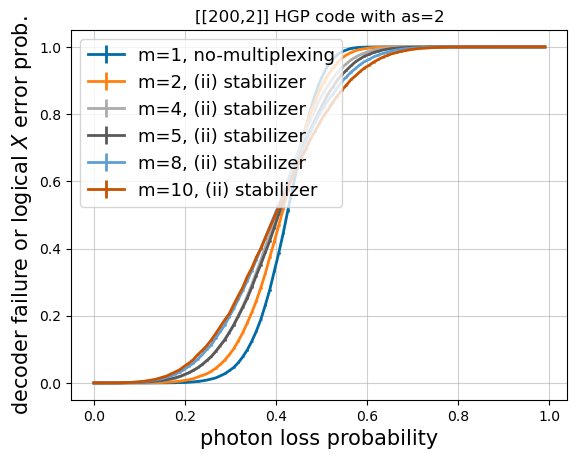

In [520]:
import_sort_and_plot_data("../results/Toric10",'as=2')

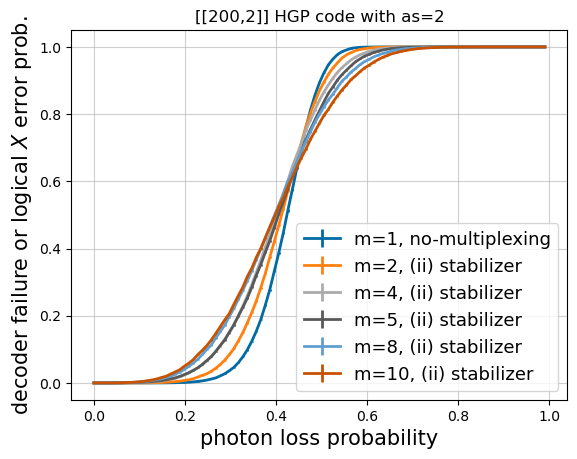

In [ ]:
import_sort_and_plot_data("../results/Toric10",'as=2')

In [ ]:
test_sorted_dict = import_files_and_sort_data("../results/n128_sym")
test_sorted_dict['as=4']

['../results/n128_sym/results_HGP_n=128_m=1_r=0.0-1.0_as=0.json',
 '../results/n128_sym/results_HGP_n=128_m=2_r=0.0-1.0_as=4.json',
 '../results/n128_sym/results_HGP_n=128_m=4_r=0.0-1.0_as=4.json',
 '../results/n128_sym/results_HGP_n=128_m=8_r=0.0-1.0_as=4.json']

In [ ]:
c0 = (128,0,0)
c1 = (255,165,0)

num_color = 5
color=[(0,0,0)]
color2= gradation(c0=c0,c1=c1,num_color=num_color)
color=color+color2

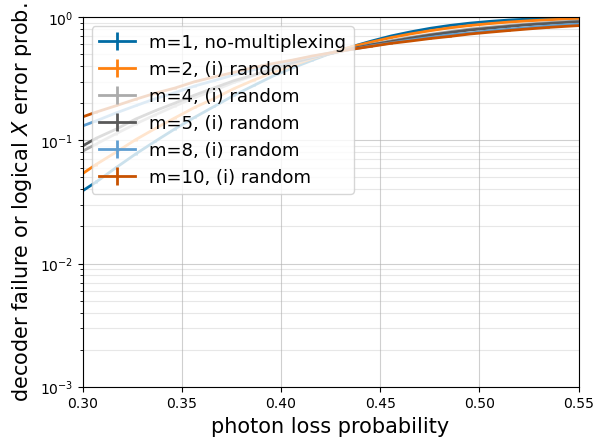

In [523]:
import_sort_and_plot_data("../results/Toric10",'as=1',log=True,save=True,title=False,xlim=[0.3,0.55],ylim=[0.001,1],color=None)

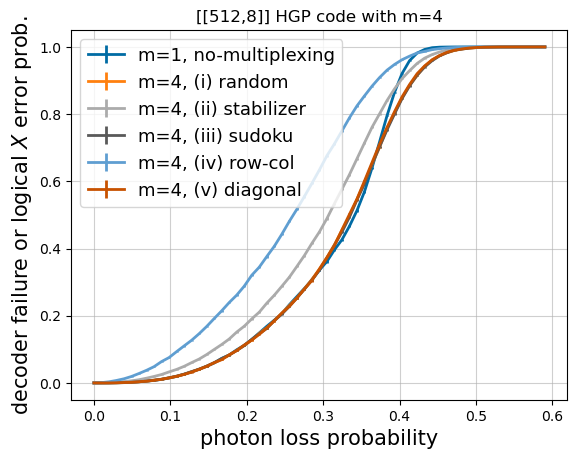

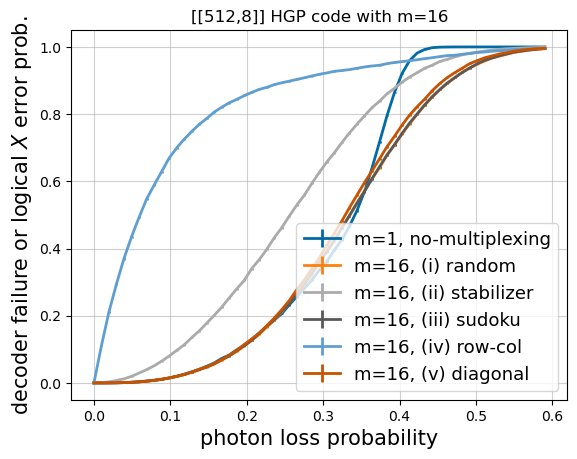

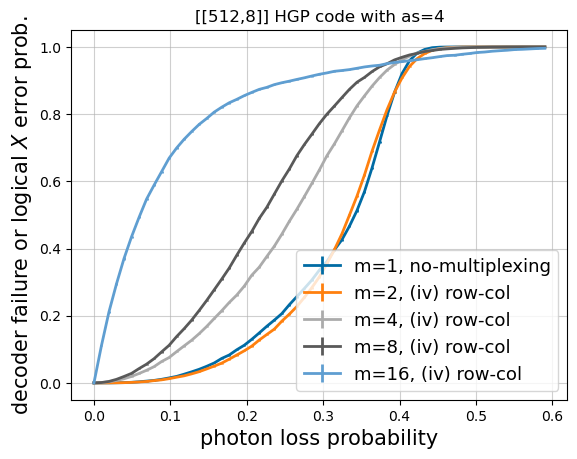

In [ ]:
import_sort_and_plot_data("../results/n512_sym_10p5",'m=4')
import_sort_and_plot_data("../results/n512_sym_10p5",'m=16')
import_sort_and_plot_data("../results/n512_sym_10p5",'as=4')

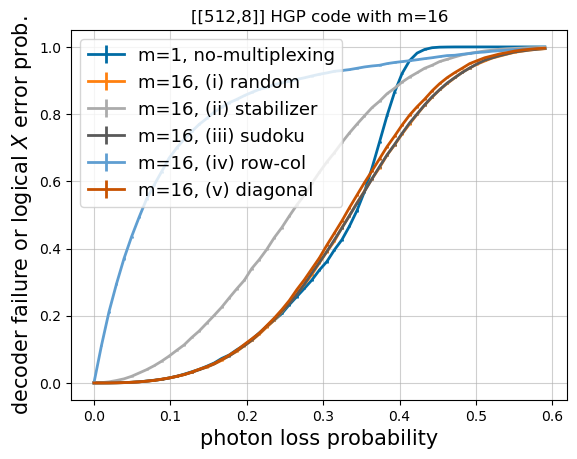

In [522]:
import_sort_and_plot_data("../results/n512_sym_10p5",'m=16',log=False)

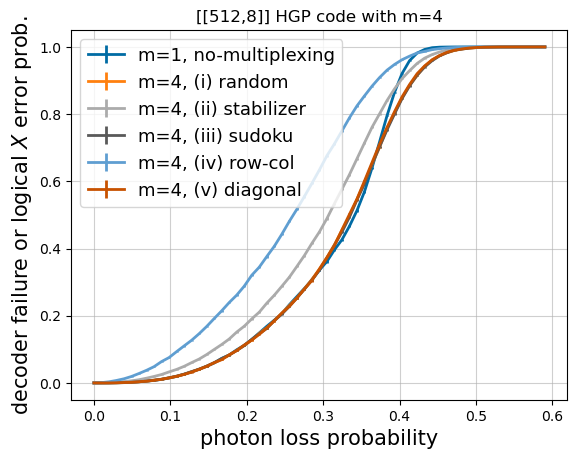

In [ ]:
import_sort_and_plot_data("../results/n512_sym_10p5",'m=4',log=False)

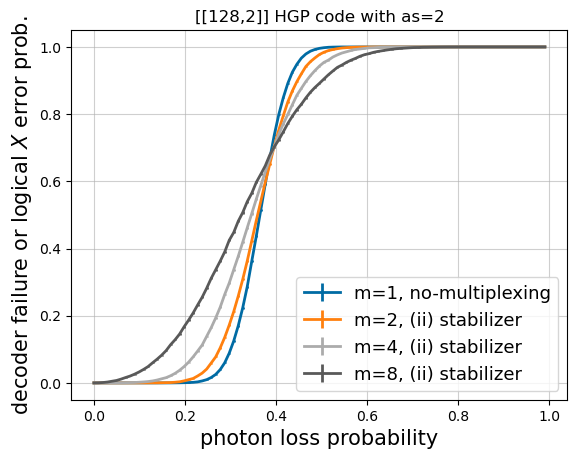

In [ ]:
import_sort_and_plot_data("../results/n128_sym",'as=2',log=False)

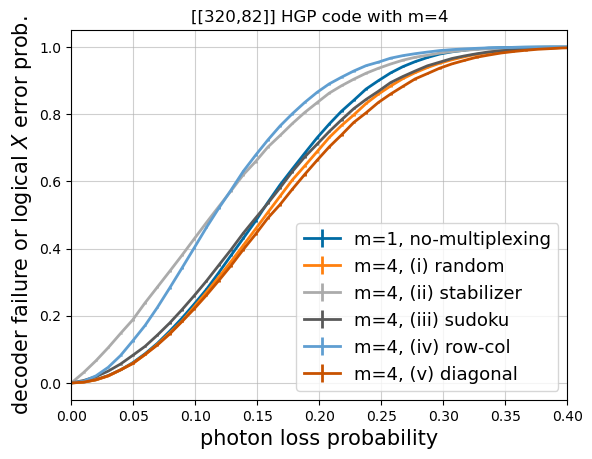

In [ ]:

import_sort_and_plot_data("../results/n320",'m=4',log=False,xlim=[0,0.4])

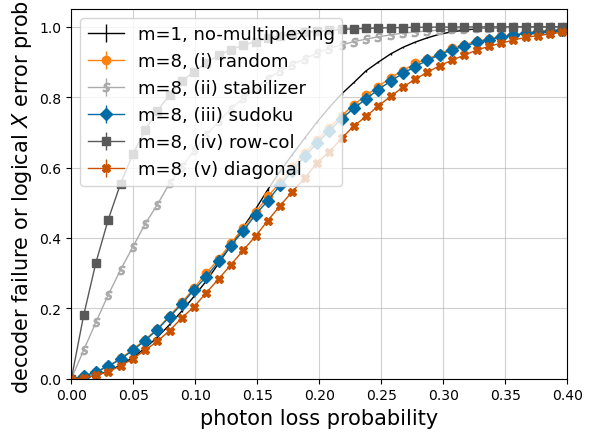

In [524]:
markers = ['none','o','$S$','D','s','X']
colors = ['black','C1','C2','C0','C3','C5']

import_sort_and_plot_data("../results/n320",'m=8',log=False,xlim=[0,0.4], ylim=[0,1.05], marker=markers, save=True, title=False,color=colors)

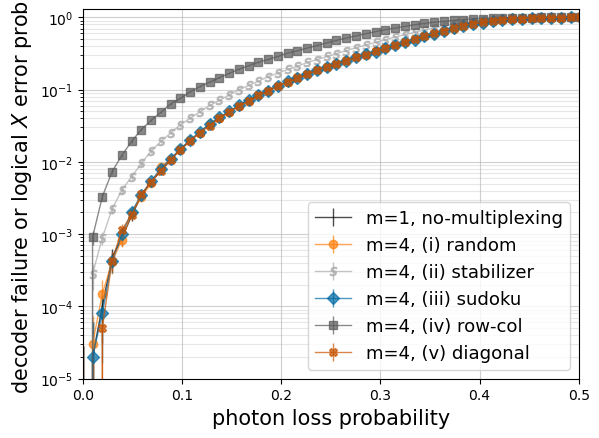

In [535]:
import_sort_and_plot_data("../results/n512_sym_10p5",'m=4',log=True,xlim=[0,0.5], ylim=[0.00001,1.3], marker=markers, save=True, title=False,color=colors)

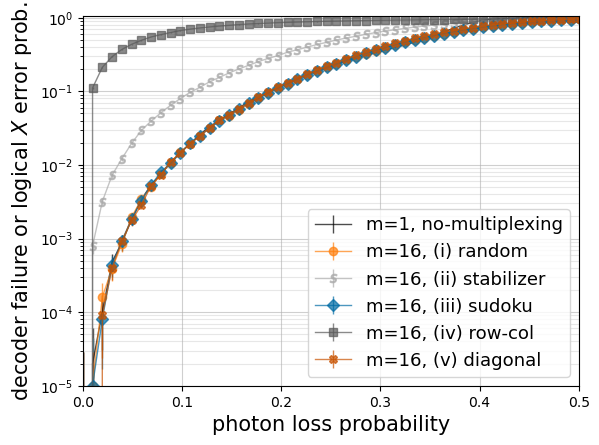

In [533]:
import_sort_and_plot_data("../results/n512_sym_10p5",'m=16',log=True,xlim=[0,0.5], ylim=[0.00001,1.05], marker=markers, save=True, title=False,color=colors)

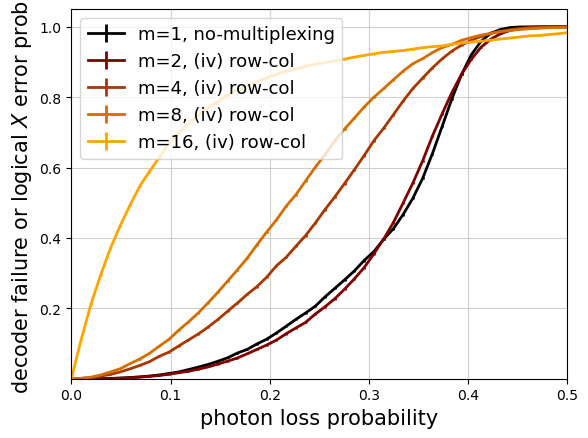

In [521]:
# colors = ['black','C0','C1','C2','C3','C4']
# c0 = (50,50,200)
# c1 = (190,165,255)

# c1 = (200,200,250)
# c0 = (0,153,153)

c0 = (128,0,0)
c1 = (255,165,0)
num_color = 4
color=[(0,0,0)]
color2= gradation(c0=c0,c1=c1,num_color=num_color)
colors=color+color2

import_sort_and_plot_data("../results/n512_sym_10p5",'as=4',log=False,xlim=[0,0.5], ylim=[0.00001,1.05], save=True, title=False,color=colors)